In [1]:
import numpy as np
import pandas as pd


X = pd.DataFrame(pd.read_pickle(r'data\mnist_data.pkl'))
y = pd.read_pickle(r'data\mnist_target.pkl')
y = y.astype(np.uint8)

In [4]:
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train.astype(np.float32)


In [5]:
# 删除空白行函数
def delete_blank(digit_image:np.ndarray):
    # 传入一个28x28的 ndarray

    (rows, cols) = digit_image.shape

    mask1 = np.array(digit_image.dot(np.ones(cols,dtype=np.float32)),dtype=bool)
    mask2 = np.array(np.ones(rows, dtype=np.float32).dot(digit_image),dtype=bool)
    
    return digit_image[mask1,:][:,mask2] 


# 删除空白行函数_plus版，因为所有digit都是28x28，所以减少了根据shape创建的one
def delete_blank_plus(data:pd.DataFrame):
    # X_train.values整个传入

    digits = data.values.reshape(60000,28,28)

    one = np.ones(28, dtype=np.float32)
    mask_row = np.array(digits.dot(one), dtype=bool)
    mask_col = np.array(one.dot(digits), dtype=bool)

    X_train_temp = []
    for i in range(len(digits)):
        X_train_temp.append(digits[i][mask_row[i],:][:,mask_col[i]])
    
    return X_train_temp

In [6]:
# 填补删减后的图片至 20×20

def add_blank_axis(digit_image:np.ndarray):
    height, width = digit_image.shape

    if (lines:= 20-height)>0:
        temp = 0
        for i in range(lines):
            if temp == 0:
                digit_image = np.insert(digit_image,height,0,axis=0)
                height = height+1
            if temp == 1:
                digit_image = np.insert(digit_image,0,0,axis=0)
            temp = 0 if temp == 1 else 1

    return digit_image

def add_blank(digit_image:np.ndarray):
    digit_image = add_blank_axis(digit_image)
    digit_image_T = add_blank_axis(digit_image.T)
    return digit_image_T.T




In [7]:
# 自定义转换器

from sklearn.base import BaseEstimator, TransformerMixin



class DataFix(BaseEstimator, TransformerMixin):
    def __init__(self):  # no *args or **kargs
        pass

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        rows = []
        for data in X.values:
            digit = data.reshape(28,28)
            digit_fix = delete_blank(digit)
            digit_fix = add_blank(digit_fix)
            rows.append(digit_fix.reshape(1,400)[0])
        X_fix = pd.DataFrame(data=rows,columns=['pixel'+str(i+1) for i in range(400)])

        
        return X_fix

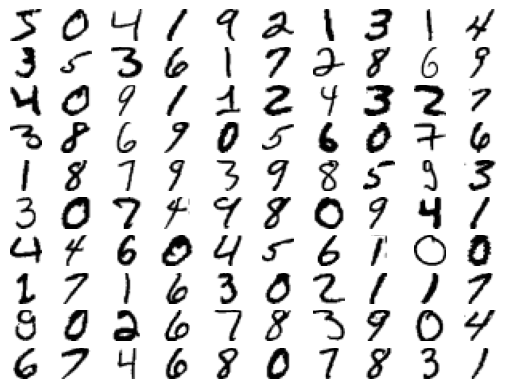

In [9]:
import matplotlib.pyplot as plt



fig,ax=plt.subplots(10, 10)
index = 0
for i in range(10):
    for j in range(10):
        some_digit = X.loc[index].values
        some_digit_image = some_digit.reshape(28, 28)
        some_digit_image = delete_blank(some_digit_image)
        some_digit_image = add_blank(some_digit_image)
        ax[i,j].imshow(some_digit_image, cmap='binary')
        ax[i,j].axis('off')
        # print('labels: ',y[index],',', 'shape: ', some_digit_image.shape, 'position:['+str(i+1)+','+str(j+1)+']')
        index += 1


In [15]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [16]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


clf = Pipeline([('fixData', DataFix()),
                ('pca', PCA(n_components=0.95)),
                ('fit',SVC(C=1, kernel='rbf'))
                ])

clf.fit(X_train, y_train_5)

Pipeline(steps=[('fixData', DataFix()), ('pca', PCA(n_components=0.95)),
                ('fit', SVC(C=1))])

In [17]:
clf.score(X_test, y_test_5)

0.9957